# Deterministic slice flows

Consider a target density $\pi(x_{1:M},u_{1:M})=p(x_{1:M})1_{[0,1]}(u_{1:M})$ 
where we have access to the full conditionals $p_m$ 
and let $F_m,Q_m$ be the cdf and quantile functions of $p_m$.
We approximate $\pi$ with a variational ergodic flow
$$
    q_N=\frac{1}{N}\sum_{n=0}^N T^nq_0,
$$
where $q_0$ is a reference distribution and
$T=T_m\circ\cdots\circ T_1$ mimics Gibbs sampling, i.e.,
each map $T_m$ updates only $(x_m,u_m)\mapsto(x_m',u_m')$.
Specifically,
$$
\begin{pmatrix}x_m'\\u_m'\end{pmatrix}=
\begin{pmatrix}
    Q_m(\rho(x_m,u_m)+\xi\mod 1)\\ 
    \frac{1}{p_m(x_m')}((\rho(x_m,u_m)+\xi\mod 1)-F(x_m'))
\end{pmatrix},
$$
where $\rho(x,u)=F_m(x-1)+up_m(x)$ converts to proportions and $F_m(0)=0$ by convention.

In the notes,
I showed that the variational density can be evaluated in closed form
since the Jacobians of the continuous restriction correspond to density ratios. Specifically,
$$
    q_N(x_{1:M},u_{1:M})
    =\frac{1}{N}\sum_{n=0}^{N-1}
    q_0(T^{-n}(x_{1:M},u_{1:M})
    \prod_{j=1}^n\prod_{m=1}^M \frac{p_m(T^{-j+1}(x_{1:M},u_{1:M}))}{p_m(T^{-j}(x_{1:M},u_{1:M}))}.
$$

First we define all the necessary functions.

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [18]:
from fractions import Fraction
tt=Fraction(12,4)
tt.denominator

1

In [161]:
########################################
########################################
# variational approximation functions
########################################
########################################
def lqN(x,u,N,lq0,prbs,xi=np.pi/16):
    if N==1: return lq0(x,u)
    w=np.zeros(N)
    w[0]=lq0(x,u)
    LJ=0
    for n in range(N-1):
        sprbs=np.sum(np.log(prbs[tuple(x)]))
        x,u=flow(x,u,1,prbs,xi,direction='bwd')
        LJ=LJ+sprbs-np.sum(np.log(prbs[tuple(x)]))
        w[n+1]=lq0(x,u)+LJ
    # end for
    return LogSumExp(w)-np.log(N)

def randqN(size,N,randq0):
    if N==1: return randq0(size)
    K=np.random.randint(low=0,high=N,size=size)
    x,u=randq0(size)
    for i in range(size): 
        tx,tu = flow(np.atleast_1d(x[i,...]),np.atleast_1d(u[i,...]),steps=K[i],prbs=prbs,xi=xi,direction='fwd')
        x[i,...]=tx
        u[i,...]=tu
    return x,u
    


########################################
########################################
# flow functions
########################################
########################################
def flow(x,u,steps,prbs,xi=np.pi/16,direction='fwd'):
    M=prbs.ndim
    if steps==0: return x,u
    for t in range(steps):
        for m in range(M):
            m_idx = m if direction=='fwd'else M-m-1 # if in reverse, update starting from the end
            #tmp_prbs=np.take(prbs,indices=x[],axis=M-m+1) # TODO HOW TO INDEX?!?!
            # TODO IMPROVE THIS BRUTE FORCE SLICING
            # we want something like tmp_prbs=prbs[x_1,x_2,...,x_{m-1},:,x_{m+1},...,x_M]
            # SOL: user inputs P as function, not array
            # function only for one component
            tmp_prbs=np.ones(prbs.shape[m_idx]) # init uniform
            tmp_x=np.copy(x)
            for i in range(prbs.shape[m_idx]):
                tmp_x[m_idx]=i
                tmp_prbs[i]=prbs[tuple(tmp_x)]
            # END TODO
            tx,tu=Tm(x[m_idx],u[m_idx],tmp_prbs/np.sum(tmp_prbs),xi,direction=direction)
            x[m_idx]=tx
            u[m_idx]=tu
        # end for
    # end for
    return x,u
        
    
def Tm(x,u,prbs,xi=np.pi/16,direction='fwd'):
    if direction=='bwd': xi=-xi
    p=getp(x,u,prbs,xi)
    xp=quantile(p,prbs)
    up=(p-cdf(xp-1,prbs))/prbs[xp]
    return xp,up


def getp(x,u,prbs,xi=np.pi/16):
    p=u*prbs[x]
    if x>0:  p+=np.sum(prbs[:x])
    return (p+xi)%1
    
########################################
########################################
# auxiliary functions
########################################
########################################
def LogSumExp(w):
    wmax = np.amax(w)
    return wmax + np.log(np.sum(np.exp(w-wmax)))
def cdf(x,prbs): return np.sum(prbs[:(x+1)])
def quantile(u,prbs): return np.argmax(np.cumsum(prbs)>u)
def numpy_gcd(a, b): 
    # from https://stackoverflow.com/questions/17537613/does-python-have-a-function-to-reduce-fractions
    a, b = np.broadcast_arrays(a, b)
    a = a.copy()
    b = b.copy()
    pos = np.nonzero(b)[0]
    while len(pos) > 0:
        b2 = b[pos]
        a[pos], b[pos] = b2, a[pos] % b2
        pos = pos[b[pos]!=0]
        return a

### Sanity check

We verify that the code is correctly inverting the flow
by running a chain for 100,000 iterations and then backpropagating.
The results are good.

In [163]:
# generate the distribution
np.random.seed(2022)
M=4
prbs=np.random.rand(M)
prbs=prbs/np.sum(prbs)
prbs

array([0.01393119, 0.74289525, 0.16878246, 0.0743911 ])

In [84]:
np.random.seed(2022)
x=1
u=np.random.rand()
steps=100000
print('Initial (x,u)=('+str(x)+','+str(u)+')')
x,u=flow(x*np.ones(1,dtype=int),u*np.ones(1),steps,prbs,np.pi/16,direction='fwd')
print('Final (x,u)=('+str(x[0])+','+str(u[0])+')')
x,u=flow(x*np.ones(1,dtype=int),u*np.ones(1),steps,prbs,np.pi/16,direction='bwd')
print('Initial (x,u)=('+str(x[0])+','+str(u[0])+')')

Initial (x,u)=(1,0.009358613807764704)
Final (x,u)=(3,0.6635161700685882)
Initial (x,u)=(1,0.009358613807750039)


## Univariate example

We generate a random probability distribution
and estimate its pmf with our algorithm.
Since the formula for $q_N$ calculates the density of the pair $(x,u)$,
we approximately marginalize by calculating an average of $q_N(x,u)$ over a grid of values of $u\in[0,1]$.
Below we show a bar plot of the exact probabilities of $x$
along with the approximation from the marginalized $q_N$ for different values of $N$.
Note that the density improves considerably as $N$ increases,
with $q_N$ being virtually identical to $p$ by $N\approx 100$.

To verify that the sampling is also correct,
we generate a sample of $q_N$ for each $N$ and plot the histogram for
the largest $N$ (which corresponds to a good variational approximation).
The resulting histogram is almost identical to the true histogram,
which suggests that the sampling is correct.

In [164]:
# setup
lq0 = lambda x,u : np.log(1/M)
def randq0(size): return np.random.randint(0,prbs.shape[0],size),np.random.rand(size)
xi=np.pi/16

# params
Ns=np.arange(1,102,10)
size=100
us=np.arange(0.,1.05,0.01)
lqs=np.zeros((M,Ns.shape[0]))
samples=np.zeros((size,Ns.shape[0]))

# get log q's and samples
for n in range(Ns.shape[0]):
    trx,tru=randqN(size,Ns[n],randq0)
    samples[:,n]=trx
    for m in range(M):
        tmp_lqs=np.zeros(us.shape[0])
        for i in range(us.shape[0]):
            tmp_lqs[i]=lqN(m*np.ones(1,dtype=int),us[i]*np.ones(1),Ns[n],lq0,prbs,xi)
        # end for
        lqs[m,n]=np.mean(tmp_lqs) # average over the uniform to marginalize
    # end for
# end for

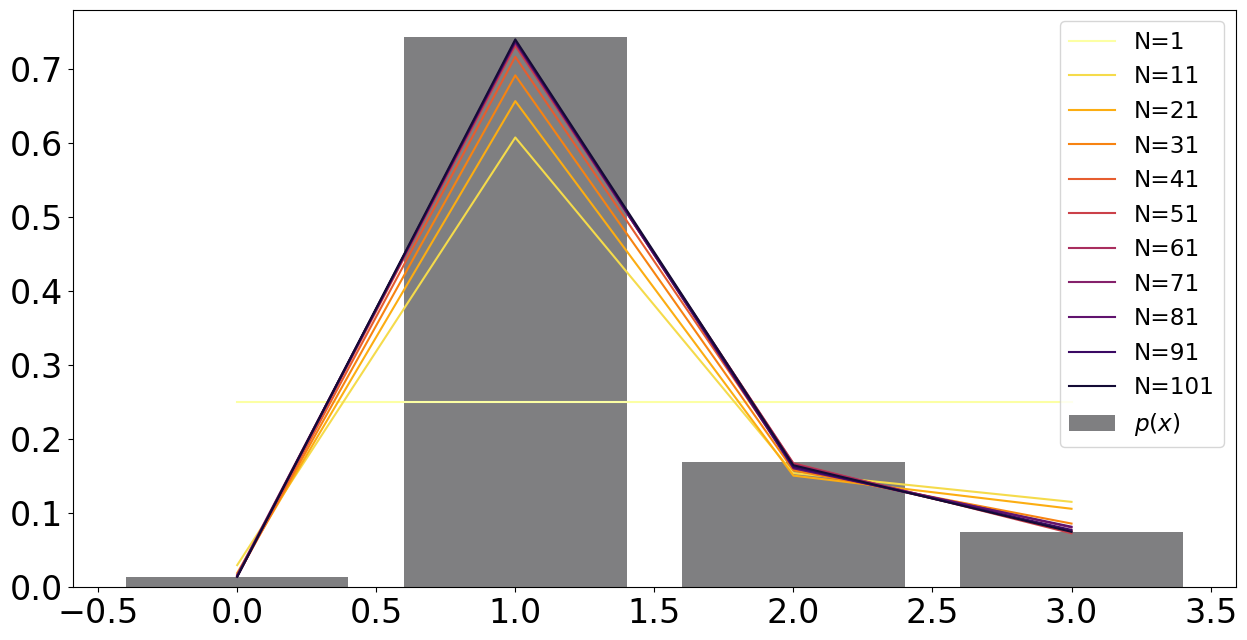

In [165]:
colors = ["#000004FF", "#140B35FF", "#3A0963FF", "#60136EFF", "#85216BFF", "#A92E5EFF", "#CB4149FF",\
          "#E65D2FFF", "#F78311FF", "#FCAD12FF", "#F5DB4BFF", "#FCFFA4FF"]

ttx=np.arange(0,prbs.shape[0])
plt.bar(ttx,prbs, alpha=0.5, label=r'$p(x)$', color=colors[0])
for n in range(Ns.shape[0]):
    ttprbs=np.exp(lqs[:,n])
    plt.plot(ttx,ttprbs,c=colors[-n-1], label='N='+str(Ns[n]))
plt.legend(fontsize='x-small')

Below we show the true histogram of $p(x)$ with the variational approximation for $N=101$.

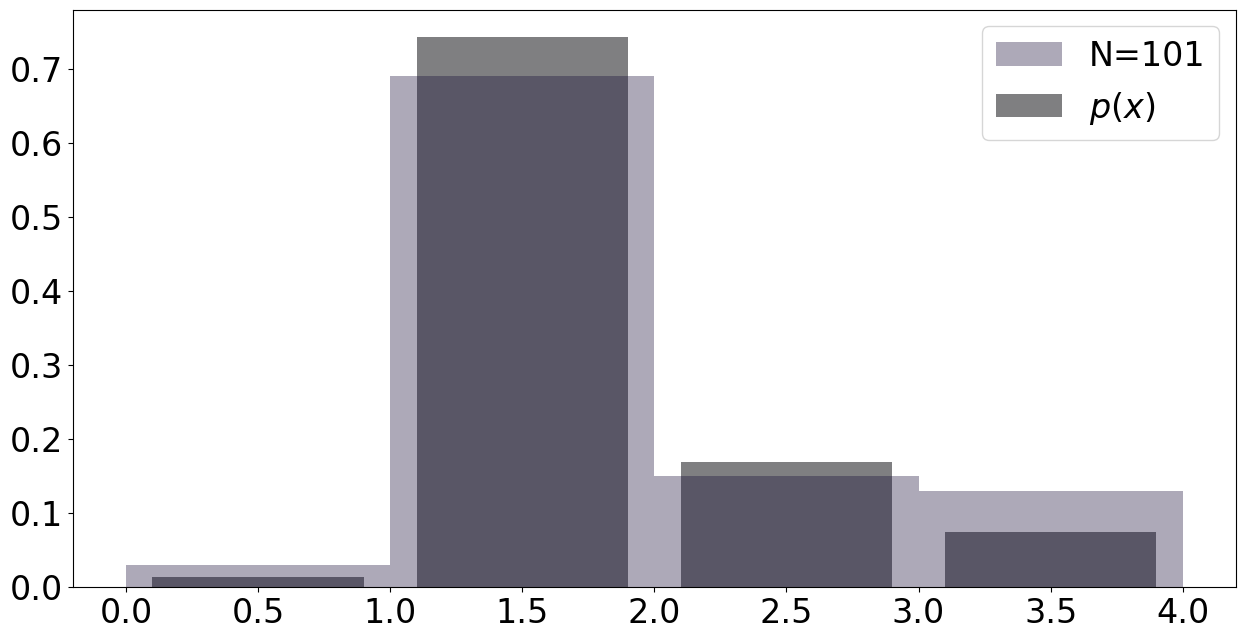

In [166]:
plt.bar(ttx+0.5,prbs, alpha=0.5, label=r'$p(x)$', color=colors[0])
plt.hist(samples[:,-1],density=True,bins=[0,1,2,3,4],alpha=0.35, label='N=101', color=colors[-Ns.shape[0]])
plt.legend()

## Bivariate example

Now we consider a random 4x4 bivariate density.
(As before, we take Trevor's example to compare.)
We now run 10,000 iterations of the chain.

In [224]:
np.random.seed(2022)
x=np.array([2,3],dtype=int)
u=np.random.rand(2)
steps=500
print('Initial (x,u)=('+str(x)+','+str(u)+')')
x,u=flow(x*np.ones(1,dtype=int),u*np.ones(1),steps,prbs,np.pi/16,direction='fwd')
print('Final (x,u)=('+str(x)+','+str(u)+')')
x,u=flow(x*np.ones(1,dtype=int),u*np.ones(1),steps,prbs,np.pi/16,direction='bwd')
print('Initial (x,u)=('+str(x)+','+str(u)+')')

Initial (x,u)=([2 3],[0.00935861 0.49905781])
Final (x,u)=([3 0],[0.48495283 0.33544239])
Initial (x,u)=([3 3],[0.91193572 0.09931798])


In [194]:
np.random.seed(2022)
K1=4
K2=5
prbs=np.random.rand(K1,K2)
prbs=prbs/np.sum(prbs)
print(prbs)

[[0.00082435 0.04395937 0.00998737 0.00440195 0.06037394]
 [0.04289621 0.07906989 0.05703064 0.07900875 0.06352097]
 [0.07322954 0.07289611 0.07342563 0.08430099 0.03241909]
 [0.04358764 0.0299056  0.05456226 0.08610543 0.00849428]]


In [195]:
# setup
lq0 = lambda x,u : np.log(1/(K1*K2))
def randq0(size): return np.vstack((np.random.randint(0,K1,size),np.random.randint(0,K2,size))).T,np.random.rand(size,size)
xi=np.pi/16

# params
Ns=np.arange(1,502,50)
size=100
us=np.arange(0.,1.05,0.01)
lqs=np.zeros((K1,K2,Ns.shape[0]))

# get log q's and samples
for n in range(Ns.shape[0]):
    for k1 in range(K1):
        for k2 in range(K2):
            tmp_lqs=np.zeros(us.shape[0])
            for i in range(us.shape[0]):
                tmp_lqs[i]=lqN(np.array([k1,k2],dtype=int),us[i]*np.ones(2),Ns[n],lq0,prbs,xi)
            # end for
            lqs[k1,k2,n]=np.mean(tmp_lqs) # average over the uniform to marginalize
    # end for
# end for

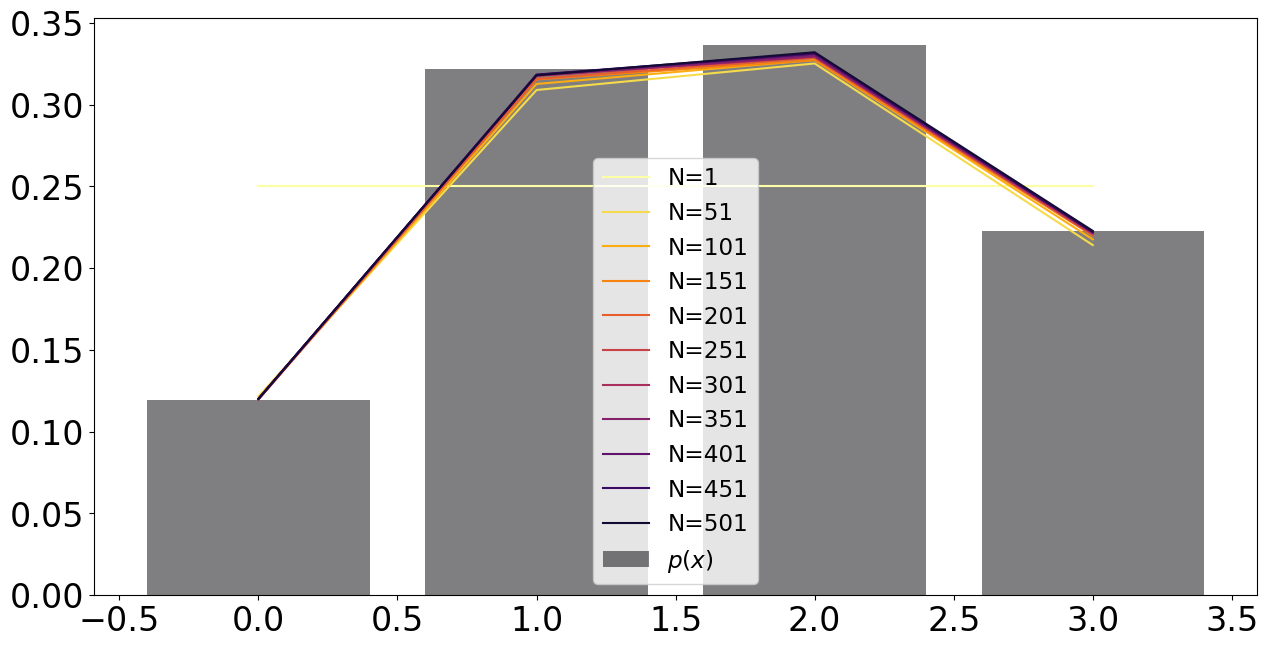

In [196]:
colors = ["#000004FF", "#140B35FF", "#3A0963FF", "#60136EFF", "#85216BFF", "#A92E5EFF", "#CB4149FF",\
          "#E65D2FFF", "#F78311FF", "#FCAD12FF", "#F5DB4BFF", "#FCFFA4FF"]

ttx=np.arange(0,K1)
plt.bar(ttx,np.sum(prbs,axis=1), alpha=0.5, label=r'$p(x)$', color=colors[0])
for n in range(Ns.shape[0]):
    ttprbs=np.sum(np.exp(lqs[:,:,n]),axis=1)
    plt.plot(ttx,ttprbs,c=colors[-n-1], label='N='+str(Ns[n]))
plt.legend(fontsize='x-small')

In [202]:
xsamples,_=randqN(1000,501,randq0)

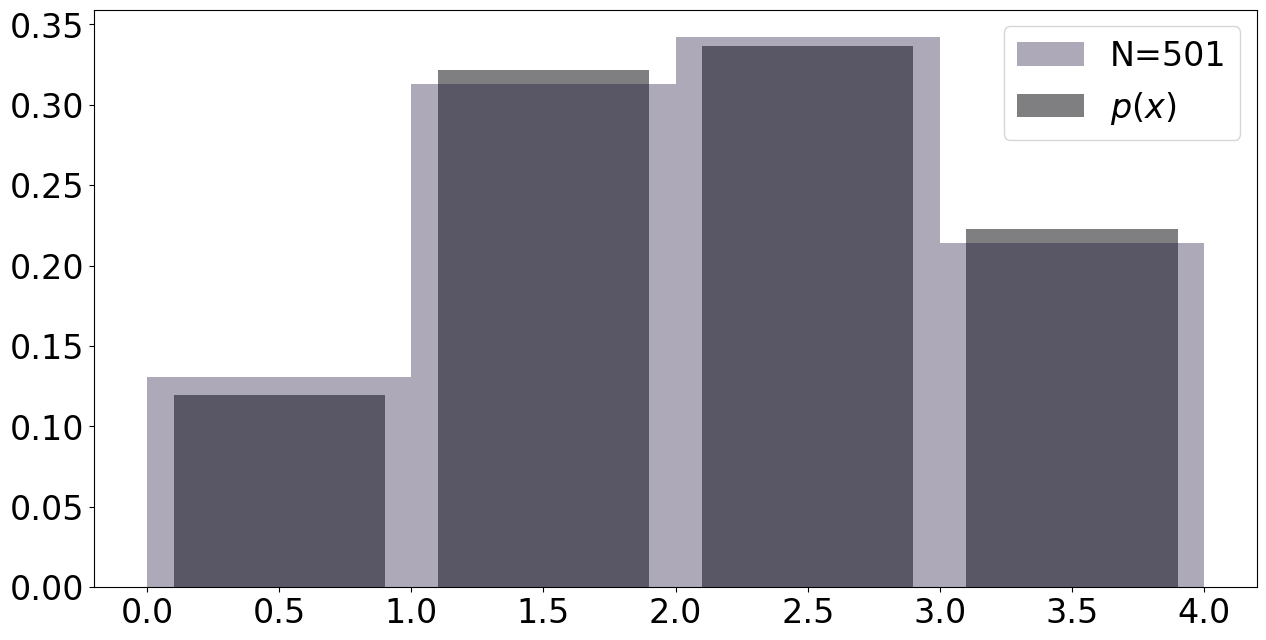

In [203]:
plt.bar(ttx+0.5,np.sum(prbs,axis=1), alpha=0.5, label=r'$p(x)$', color=colors[0])
plt.hist(xsamples[:,0],density=True,bins=[0,1,2,3,4],alpha=0.35, label='N=501', color=colors[-Ns.shape[0]])
plt.legend()